In [22]:
import random
import matplotlib.pyplot as plt
import networkx as nx

**The Plan**
- Define a super simple MDP. Start without any cycles, literally just make it a directed acyclic graph.
- Assign random numbers to all state-action pairs in this MDP (e.g. sampled from a gaussian with mean 0, variance 1), i.e. a maximally dense reward function.
- Write a function which computes the set of optimal policies assuming that those numbers are interpreted as a reward function.
- Generate many (e.g. 1000) random reward functions, and check that the optimal policies they lead to are non-uniform, i.e. some policies are more likely than others to be generated via this process.

Hypotheses: (speculative)
- Some policies will be more likely than others to be generated (what structure in particular?)

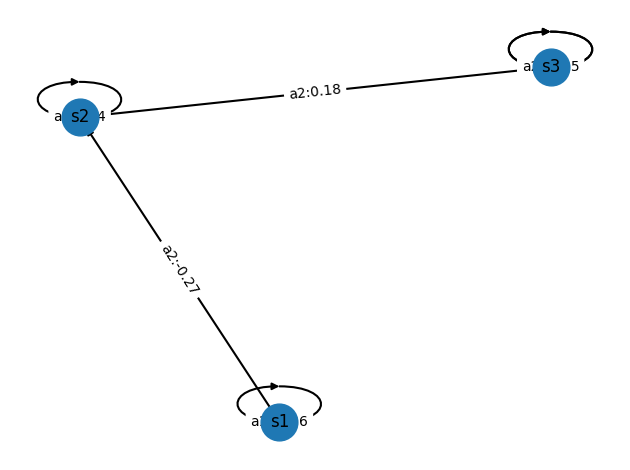

MDP Summary:
States: s1, s2, s3
Actions: a1, a2
Discount Factor: 0.9
Optimal Policy: {'s1': 'a2', 's2': 'a1', 's3': 'a2'}


In [23]:
### Defining a markov decision process
### Thanks ChatGPT (again)

import numpy as np

class MDP:
    def __init__(self, states, actions, transition_function, reward_function, gamma):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function  # Function: (s, a, s') -> Probability
        self.reward_function = reward_function  # Function: (s, a, s') -> Reward, now passed during initialization
        self.gamma = gamma

    def get_possible_actions(self, state):
        return self.actions

    def transition(self, state, action):
        return [(self.transition_function(state, action, next_state),
                 next_state,
                 self.reward_function(state, action, next_state))
                for next_state in self.states]

    def compute_optimal_policy_value(self, values):
        # Initialize the policy for each state to None
        policy = {state: None for state in self.states}

        # After the value function has converged, determine the optimal policy
        for state in self.states:
            # Calculate the expected value of each action using the converged value function
            action_values = {
                action: sum(p * (reward + self.gamma * values[next_state])
                            for p, next_state, reward in self.transition(state, action))
                for action in self.get_possible_actions(state)
            }

            # Select the action that has the highest expected value
            # print(action_values)
            max_value = float("-inf")
            max_action = None
            for action, value in action_values.items():
                if value > max_value or abs(value - max_value) < 1e-9 and random.choice([True, False]):
                    max_value = value
                    max_action = action
            policy[state] = max_action

        # Return the optimal policy and the converged value function
        return policy
    
    def compute_optimal_policy(self, epsilon=0.01, max_iterations=1000):
        # Initialize the value function for each state to zero
        values = {state: 0 for state in self.states}

        # Repeat until convergence or maximum iterations reached
        for _ in range(max_iterations):
            # Keep track of the maximum change in the value function across all states
            delta = 0

            # Update the value function for each state
            for state in self.states:
                # Store the current value function for the state
                v = values[state]

                # Calculate the value for all possible actions from the current state
                action_values = [
                    sum(p * (reward + self.gamma * values[next_state])
                        for p, next_state, reward in self.transition(state, action))
                    for action in self.get_possible_actions(state)
                ]

                # Update the value function to the maximum value across all actions
                values[state] = max(action_values)

                # Update delta to the maximum change in the value function
                delta = max(delta, abs(v - values[state]))

            # If the maximum change in the value function is less than epsilon, we've converged
            if delta < epsilon:
                # print(f"Converged after {_} iterations")
                break
        return self.compute_optimal_policy_value(values)

    def plot_graph(self):
        G = nx.MultiDiGraph()

        # Add nodes for each state
        for state in self.states:
            G.add_node(state)

        # Add edges for each action and transition
        for state in self.states:
            for action in self.actions:
                for next_state in self.states:
                    if self.transition_function(state, action, next_state) > 0:
                        reward = self.reward_function(state, action, next_state)
                        G.add_edge(state, next_state, action=action, weight=reward)

        # plt.figure(figsize=(12, 8))  # Increase the plot size
        pos = nx.spring_layout(G, k=0.5, iterations=20)  # k: Optimal distance between nodes. Increase/decrease to spread nodes out

        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_labels(G, pos)

        # Draw edges and add labels
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.5)

        edge_labels = {(u, v): f"{d['action']}:{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
        
        # Calculate edge label positions at the midpoint of the edges
        edge_label_pos = {edge: ((pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2) 
                        for edge in G.edges()}

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.axis('off')
        plt.tight_layout()  # Adjust layout to prevent cutting off edge labels
        plt.show()

    def __str__(self):
        states_str = ', '.join(self.states)
        actions_str = ', '.join(self.actions)
        return (f"MDP Summary:\n"
                f"States: {states_str}\n"
                f"Actions: {actions_str}\n"
                f"Discount Factor: {self.gamma}")


# Example MDP setup
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
def transition_function(s, a, s_prime): #simple function for demonstration
    if a == actions[0]:
        return 1 if s_prime == s else 0
    else: # s1 to s2, s2 to s3
        return 1 if (s == 's1' and s_prime == 's2') or (s == 's2' and s_prime == 's3') or (s == 's3' and s_prime == 's3') else 0

# Define a reward function that assigns random rewards for each state-action pair
def random_reward_function(states, actions):
    """Initializes a reward function that assigns random rewards to state-action pairs."""
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = np.random.normal(0, 1) if transition_function(state, action, next_state) > 0 else 0
                # Gaussian distribution, mean=0, variance=1
    # print(rewards)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

gamma = 0.9 # Discount factor
# Create an MDP object with the randomized reward function

mdp = MDP(states, actions, transition_function, random_reward_function(states, actions), gamma)
optimal_policy = mdp.compute_optimal_policy()
mdp.plot_graph()
print(mdp)
print("Optimal Policy:", optimal_policy)

In [24]:
### Oops, there's already a function for this in the mdptoolbox library
import mdptoolbox, mdptoolbox.example
import numpy as np

# Generate a simple example MDP problem
P, R = mdptoolbox.example.forest(S=3, r1=4, r2=2, p=0.1)

# P is the transition probability matrix
# P[action][state, nextState] = probability of transitioning from state to nextState given action
# R is the reward matrix
# R[state, action] = reward received when taking action in state

# Initialize the Value Iteration algorithm
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)

# Run the Value Iteration algorithm
vi.run()

# Output results
print("Policy:", vi.policy)  # Best action in each state
print("Value:", vi.V)  # Value of each state


Policy: (0, 0, 0)
Value: (5.051970000000001, 8.291970000000001, 12.291970000000001)


In [25]:
### Test 1000 reward functions, see what policies we get

NUM_REWARD_FUNCTIONS = 1000
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
gamma = 0.9

def collate_results(optimal_policies, print_result = True):
    opt_pol_counts = {}
    for policy in optimal_policies:
        key = str(policy)
        if key in opt_pol_counts:
            opt_pol_counts[key] += 1
        else:
            opt_pol_counts[key] = 1
    
    if print_result:
        print("Optimal Policy Counts:")
        sorted_keys = sorted(opt_pol_counts.keys())
        for key in sorted_keys:
            print(key, ":", opt_pol_counts[key])
    return opt_pol_counts

def test_randomness(states, actions, gamma, print_result = True, transition_function = transition_function):
    random_reward_functions = [random_reward_function(states, actions) for _ in range(NUM_REWARD_FUNCTIONS)]

    mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
    optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]
    # optimal_policies = [mdp.compute_optimal_policy() for mdp in ([mdps[0]] * 1000)] 
    # ^ debug to make sure compute_optimal_policy is deterministic
    # print("Optimal Policies:", optimal_policies)

    return collate_results(optimal_policies, print_result)

pol_counts = {}
for _ in range(10):
    entry = test_randomness(states, actions, gamma)
    for k in entry.keys():
        if k in pol_counts:
            pol_counts[k] += entry[k]
        else:
            pol_counts[k] = entry[k]
pol_counts

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 37
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 47
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 78
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 92
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 130
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 120
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 247
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 249
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 38
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 39
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 80
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 113
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 152
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 132
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 218
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 228
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 52
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 54
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 99
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 92
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 125
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 

{"{'s1': 'a2', 's2': 'a2', 's3': 'a2'}": 2360,
 "{'s1': 'a2', 's2': 'a1', 's3': 'a2'}": 1285,
 "{'s1': 'a2', 's2': 'a2', 's3': 'a1'}": 2417,
 "{'s1': 'a1', 's2': 'a2', 's3': 'a2'}": 941,
 "{'s1': 'a1', 's2': 'a2', 's3': 'a1'}": 897,
 "{'s1': 'a1', 's2': 'a1', 's3': 'a2'}": 434,
 "{'s1': 'a2', 's2': 'a1', 's3': 'a1'}": 1250,
 "{'s1': 'a1', 's2': 'a1', 's3': 'a1'}": 416}

- Sanity check: since a1 and a2 do exactly the same thing at s3 (100% chance of going back to s3), the number of times two policies that differ only by s3's action are optimal should be roughly equal. This is indeed what we find
- At least based off the simple transition function we wrote earlier, there are clear differences in which policies are preferred (not uniform). Not sure about exactly why

In [26]:
### Chi-squared test for optimal policy counts (null hypothesis: all policies are equally likely)
from scipy.stats import chisquare

NUM_REWARD_FUNCTIONS = 10**3
NUM_VALUE_FUNCTIONS = 10**3
def chi_squared_test(opt_pol_counts, reward_or_value = True):
    expected = [(NUM_REWARD_FUNCTIONS if reward_or_value else NUM_VALUE_FUNCTIONS) / len(opt_pol_counts)] * len(opt_pol_counts)
    chi2, p = chisquare(list(opt_pol_counts.values()), f_exp=expected)
    print(f"Chi-squared: {chi2}, p-value: {p}")

for _ in range(3):
    chi_squared_test(test_randomness(states, actions, gamma))

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 37
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 51
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 94
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 89
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 133
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 123
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 236
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 237
Chi-squared: 323.28, p-value: 6.414502770014657e-66
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 52
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 45
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 100
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 89
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 140
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 138
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 227
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 209
Chi-squared: 252.03199999999998, p-value: 1.0234509714305534e-50
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 47
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 43
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 109
{'s1':

In [27]:
### Sparse reward function test

def sparse_reward_function(states, actions, sparsity = 0.9):
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = 0 if random.random() < sparsity else np.random.normal(0, 1)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

def test_sparsity(states, actions, gamma, sparsity = 0.9, print_result = True, transition_function = transition_function):
    random_reward_functions = [sparse_reward_function(states, actions, sparsity) for _ in range(NUM_REWARD_FUNCTIONS)]

    mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
    optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]

    return collate_results(optimal_policies, print_result)


for i in [0.1, 0.5, 0.9, 0.99, 0.999, 0.9999]:
    test_sparsity(states, actions, gamma, i)

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 43
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 57
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 78
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 85
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 110
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 136
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 255
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 236
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 49
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 51
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 84
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 93
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 134
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 121
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 233
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 235
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 89
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 105
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 110
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 98
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 127
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} :

- The distribution of policies evens out to uniform as sparsity increases

In [28]:
### Directly inserting a value function

def test_value_function(states, actions, gamma, print_result = True, transition_function = transition_function):
    values = [{state: random.random() for state in states} for _ in range(NUM_VALUE_FUNCTIONS)]
    mdp = [MDP(states, actions, transition_function, random_reward_function(states, actions), gamma) for _ in range(NUM_VALUE_FUNCTIONS)]
    opt_policies = [mdp[i].compute_optimal_policy_value(values[i]) for i in range(NUM_VALUE_FUNCTIONS)]
    return collate_results(opt_policies, print_result)

for _ in range(3):
    chi_squared_test(test_value_function(states, actions, gamma))
    

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 108
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 130
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 128
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 139
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 134
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 110
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 129
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 122
Chi-squared: 6.800000000000001, p-value: 0.44999681158102467
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 124
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 124
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 145
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 106
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 133
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 141
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 115
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 112
Chi-squared: 10.816, p-value: 0.14684882318982984
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 110
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 111
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 121
{'s

**Hypotheses**:
1. Maybe reward-generated optimal policies loop more often
2. Maybe they try not to get stuck (preserve optionality/power-seeking)
3. Maybe they go for more options

In [29]:
### A more complicated MDP

NUM_REWARD_FUNCTIONS = 10**4
states = ['s1', 's2', 's3', 's4', 's5', 's6', 's7']
actions = ['a1', 'a2', 'a3']
gamma = 0.9
def transition_function(s, a, s_prime):
    if a == actions[0]:
        return 1 if s == s_prime else 0
    elif a == actions[1]:
        return 1 if (s == 's1' and s_prime == 's2') or (s == 's2' and s_prime == 's4') or (s == 's3' and s_prime == 's5') or (s == 's5' and s_prime == 's6') or (s == 's6' and s_prime == 's7') else 0
    else:
        return 1 if (s == 's1' and s_prime == 's3') or (s == 's2' and s_prime == 's3')  or (s == 's3' and s_prime == 's2') else 0

def concise_printing(opt_pol_counts):
    print("Optimal Policy Counts:")
    sorted_keys = sorted(opt_pol_counts.keys())
    out = ""
    for key in sorted_keys:
        out += (str(opt_pol_counts[key]) + ", ")
    print(out)

def print_top_k(opt_pol_counts, k=5):
    sorted_keys = sorted(opt_pol_counts.keys(), key = lambda x: -opt_pol_counts[x])
    for key in sorted_keys[:k]:
        print(key, ":", opt_pol_counts[key])

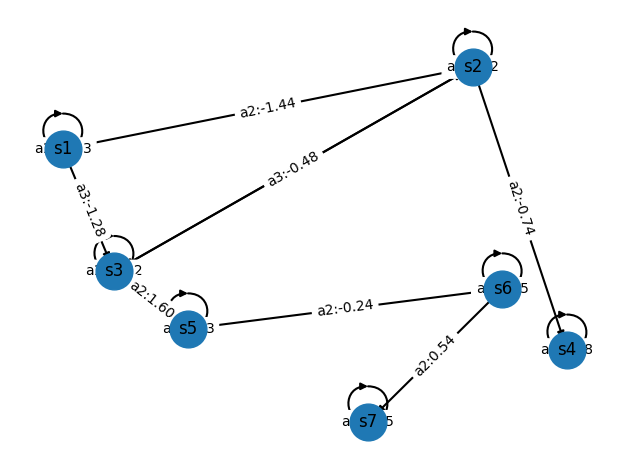

Optimal Policy Counts:
17, 7, 10, 13, 2, 3, 10, 6, 5, 6, 5, 4, 3, 3, 4, 5, 2, 4, 1, 3, 4, 2, 1, 6, 2, 4, 2, 1, 3, 3, 2, 1, 2, 2, 1, 1, 5, 4, 2, 2, 3, 4, 1, 1, 2, 1, 4, 3, 3, 4, 8, 5, 5, 5, 1, 6, 3, 3, 3, 1, 3, 1, 2, 2, 4, 1, 2, 1, 1, 2, 18, 5, 6, 16, 3, 5, 9, 6, 6, 11, 3, 4, 4, 2, 4, 4, 1, 3, 7, 1, 8, 5, 2, 1, 2, 2, 1, 7, 5, 2, 4, 3, 2, 4, 2, 3, 3, 1, 1, 2, 11, 1, 1, 1, 1, 1, 4, 2, 1, 12, 7, 6, 6, 3, 2, 3, 2, 3, 4, 5, 4, 2, 1, 1, 2, 7, 1, 7, 1, 4, 1, 4, 3, 1, 15, 6, 8, 12, 5, 5, 9, 7, 4, 11, 4, 3, 8, 3, 5, 6, 4, 4, 11, 7, 4, 1, 2, 2, 8, 2, 3, 5, 3, 4, 5, 2, 3, 4, 1, 6, 3, 3, 1, 1, 1, 4, 1, 4, 4, 5, 2, 1, 1, 3, 2, 1, 8, 3, 3, 4, 4, 4, 1, 2, 8, 4, 1, 1, 1, 2, 3, 3, 1, 2, 2, 1, 2, 2, 31, 14, 10, 17, 4, 7, 17, 8, 4, 13, 5, 13, 12, 5, 3, 16, 3, 2, 11, 8, 9, 5, 5, 7, 6, 7, 4, 10, 2, 8, 4, 4, 5, 4, 4, 2, 6, 4, 6, 5, 1, 4, 1, 7, 6, 2, 1, 1, 4, 3, 2, 13, 7, 7, 6, 2, 2, 5, 3, 4, 8, 2, 7, 1, 2, 1, 7, 3, 2, 6, 6, 6, 6, 2, 1, 3, 2, 15, 8, 12, 10, 4, 1, 11, 4, 6, 12, 3, 6, 9, 3, 3, 6, 5, 4, 12, 4, 3

In [30]:
MDP(states, actions, transition_function, random_reward_function(states, actions), gamma).plot_graph()
opt_pol_counts = test_randomness(states, actions, gamma, False)
concise_printing(opt_pol_counts)
print(len(opt_pol_counts)) # 3^7 = 2187, but not all policies are enumerated
chi_squared_test(opt_pol_counts)
print_top_k(opt_pol_counts, 10)

- Definitely seems like optimal policies gravitate towards loops; some kind of "explore-exploit" dynamic going on
- s1 and s2 tend to gravitate towards a3, meaning that optionality/power-seeking is favored, although this conclusion is less strong in my opinion
- Clearly the distribution of optimal policies is *very* non-uniform, even with a more complicated MDP

In [31]:
NUM_REWARD_FUNCTIONS = 10**3
for i in [0.1, 0.5, 0.7, 0.8, 0.9, 0.99]:
    opt_pol_counts = test_sparsity(states, actions, gamma, i, False)
    chi_squared_test(opt_pol_counts)
    print_top_k(opt_pol_counts)

Chi-squared: 290.53, p-value: 1.0
{'s1': 'a3', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 6
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 5
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 5
{'s1': 'a2', 's2': 'a2', 's3': 'a2', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a2'} : 5
{'s1': 'a3', 's2': 'a2', 's3': 'a2', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a2'} : 5
Chi-squared: 222.62800000000001, p-value: 1.0
{'s1': 'a3', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a3', 's6': 'a1', 's7': 'a1'} : 6
{'s1': 'a3', 's2': 'a2', 's3': 'a2', 's4': 'a1', 's5': 'a1', 's6': 'a3', 's7': 'a3'} : 4
{'s1': 'a2', 's2': 'a3', 's3': 'a3', 's4': 'a3', 's5': 'a2', 's6': 'a3', 's7': 'a3'} : 4
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a3', 's5': 'a3', 's6': 'a1', 's7': 'a3'} : 4
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 4
Chi-squared: 229.5799999999999

- Sparsity is still a little weird to me: it doesn't seem like it has a dramatic effect until *all* (s, a, s') rewards go to 0, in which case the optimal policy becomes random. This tells me that maybe the force affecting the non-uniformness of optimal policies has more to do with the structure of the MDP than sparsity.

In [32]:
NUM_VALUE_FUNCTIONS = 10**4
opt_pol_counts = test_value_function(states, actions, gamma, False)
chi_squared_test(opt_pol_counts, False)
print_top_k(opt_pol_counts, k = 10)

Chi-squared: 34620.579600000005, p-value: 0.0
{'s1': 'a1', 's2': 'a3', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 137
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 135
{'s1': 'a1', 's2': 'a1', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 135
{'s1': 'a2', 's2': 'a3', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 132
{'s1': 'a3', 's2': 'a1', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 114
{'s1': 'a1', 's2': 'a2', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 99
{'s1': 'a2', 's2': 'a2', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 92
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 89
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 79
{'s1': 'a2', 's2': 'a3', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 77


Two ideas to test:
1. Are random policies "power-seeking" (in the Turner definition, i.e. pursue optionality)? If true, this would undermine existing results
2. What other hypotheses are there about policies in MDPs? (e.g. length of loop = "goal complexity", distance to loop = "agency") The end goal here would be some non-trivial demonstration of X hypothesis

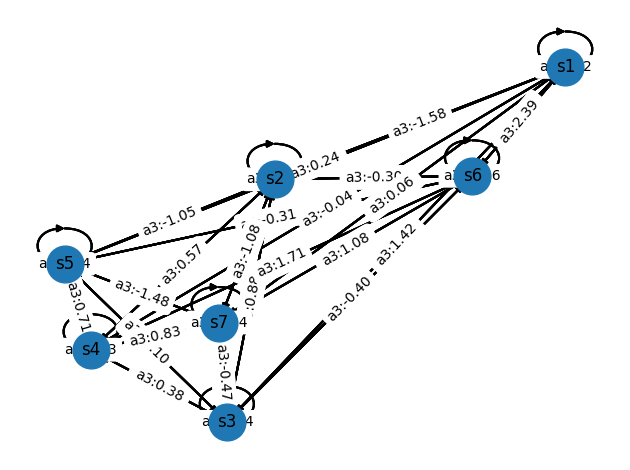

Randomness Test:
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a2', 's7': 'a1'} : 4
{'s1': 'a1', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a2', 's7': 'a2'} : 3
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 3
{'s1': 'a2', 's2': 'a2', 's3': 'a1', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a2'} : 3
{'s1': 'a2', 's2': 'a3', 's3': 'a1', 's4': 'a2', 's5': 'a3', 's6': 'a1', 's7': 'a3'} : 3
Chi-squared: 160.43199999999996, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a3', 's2': 'a3', 's3': 'a3', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 6
{'s1': 'a1', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a1', 's7': 'a1'} : 6
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a2', 's7': 'a2'} : 5
{'s1': 'a2', 's2': 'a2', 's3': 'a1', 's4': 'a2', 's5': 'a3', 's6': 'a1', 's7': 'a2'} : 5
{'s1': 'a1', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a3', 's6': 'a3', 's7': 'a3'} : 5
Chi-squared: 285.

In [41]:
NUM_MDPs = 1

for _ in range(NUM_MDPs):
    # Generate random transition function and reward function
    def random_transition_function():
        transitions = {}
        for state in states:
            for action in actions:
                probs = np.random.dirichlet(np.ones(len(states)))
                # print(probs)
                for i, next_state in enumerate(states):
                    transitions[(state, action, next_state)] = probs[i]
        return lambda s, a, s_prime: transitions[(s, a, s_prime)]
    
    # Create MDP object
    transition_function = random_transition_function()
    reward_function = lambda s, a, s_prime: np.random.normal(0, 1) if transition_function(s, a, s_prime) > 0 else 0
    mdp = MDP(states, actions, transition_function, reward_function, gamma)
    mdp.plot_graph()
    
    # Run tests (reward randomized each time)
    print("Randomness Test:")
    results1 = test_randomness(states, actions, gamma, False, transition_function)
    print_top_k(results1, 5)
    chi_squared_test(results1)
    
    print("Sparsity Test: (sparsity 0.9)")
    results2 = test_sparsity(states, actions, gamma, 0.9, False, transition_function)
    print_top_k(results2, 5)
    chi_squared_test(results2)
    
    print("Value Function Test:")
    results3 = test_value_function(states, actions, gamma, False, transition_function)
    print_top_k(results3, 5)
    chi_squared_test(results3, False)
    
    print("-------------------------")


- After running the above block of code a few times, it seems like when you run the experiments on a denser graph (where the transition function can possibly send the policy to any other state), the non-uniformity results break down. Perhaps our hypotheses (e.g. that loops or out-arrows matter) depend on a "sparse" MDP